<br>

## About AdventureWorks2022
Adventure Works is a fictional company that manufactures and sells bicycles and related accessories. Its operations cover areas such as human resources, production, sales, and customer management. The AdventureWorks2022 database contains information on employees, products, orders, and customers. The company offers a wide product range, primarily consisting of bicycles, bicycle components, and accessories.

---

<br>

In [29]:
from sqlalchemy import create_engine, inspect
from scipy.stats import norm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [30]:
# Create a database connection via SQLAlchemy to the specified SQL Server.
def new_engine(
    dialect: str,
    server: str,
    database: str,
    user: str | None = None,
    password: str | None = None,
    integrated_security: bool = True,
):

    if integrated_security:
        # Windows authentication
        connection_str = (
            f"{dialect}://{server}/{database}"
            "?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
        )
    else:
        # SQL Server authentication
        connection_str = (
            f"{dialect}://{user}:{password}@{server}/{database}"
            "?driver=ODBC+Driver+17+for+SQL+Server"
        )

    return create_engine(connection_str)

engine = new_engine(
    dialect="mssql",
    server="Lence",
    database="AdventureWorks2022",
    integrated_security=True
)

connection = engine.connect()

In [31]:
# List schemas with tables (excluding 'dbo')
inspector = inspect(engine)

df_schemas_with_tables = (
    pd.DataFrame([

        {"Schema": s, "Number of Tables": len(inspector.get_table_names(schema=s))}
        for s in inspector.get_schema_names() if s != "dbo"
    ])
    .query("`Number of Tables` > 0")  # Filter out schemas without tables
    .sort_values("Number of Tables", ascending=False)  # Sort by number of tables (descending)
    .reset_index(drop=True)  # Reset index for a cleaner table
)

df_schemas_with_tables


,Schema,Number of Tables
0,Production,25
1,Sales,19
2,Person,14
3,HumanResources,6
4,Purchasing,5


<br>

## Data Collection and SQL Queries

In [32]:
# SQL queries to retrieve key metrics
queries = {
    "customers_per_territory": """
        SELECT COALESCE(st.Name,'Unknown') AS TerritoryName,
               COUNT(*) AS CustomerCount
        FROM Sales.Customer c
        LEFT JOIN Sales.SalesTerritory st ON c.TerritoryID = st.TerritoryID
        GROUP BY COALESCE(st.Name,'Unknown');
    """,
    "orders_per_year": """
        SELECT YEAR(OrderDate) AS [Year],
               COUNT(*) AS NumberOfOrders
        FROM Sales.SalesOrderHeader
        GROUP BY YEAR(OrderDate);
    """,
    "products_per_category": """
        SELECT COALESCE(pc.Name,'Uncategorized') AS CategoryName,
               COUNT(p.ProductID) AS ProductCount
        FROM Production.Product p
        LEFT JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
        LEFT JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
        GROUP BY COALESCE(pc.Name,'Uncategorized');
    """,
    "employees_per_department": """
        SELECT d.Name AS DepartmentName,
               COUNT(DISTINCT edh.BusinessEntityID) AS NumberOfEmployees
        FROM HumanResources.EmployeeDepartmentHistory edh
        JOIN HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
        WHERE edh.EndDate IS NULL
        GROUP BY d.Name;
    """,
}

# Execute the queries and store the results in DataFrames
dfs = {name: pd.read_sql_query(sql, engine) for name, sql in queries.items()}

# Sort results for clearer presentation
df_customers_per_territory = dfs["customers_per_territory"].sort_values("CustomerCount", ascending=False)
df_orders_per_year = dfs["orders_per_year"].astype({"Year": "int64"}).sort_values("Year")
df_products_per_category = dfs["products_per_category"].sort_values("ProductCount", ascending=False)
df_employees_per_department = dfs["employees_per_department"].sort_values("NumberOfEmployees", ascending=False)

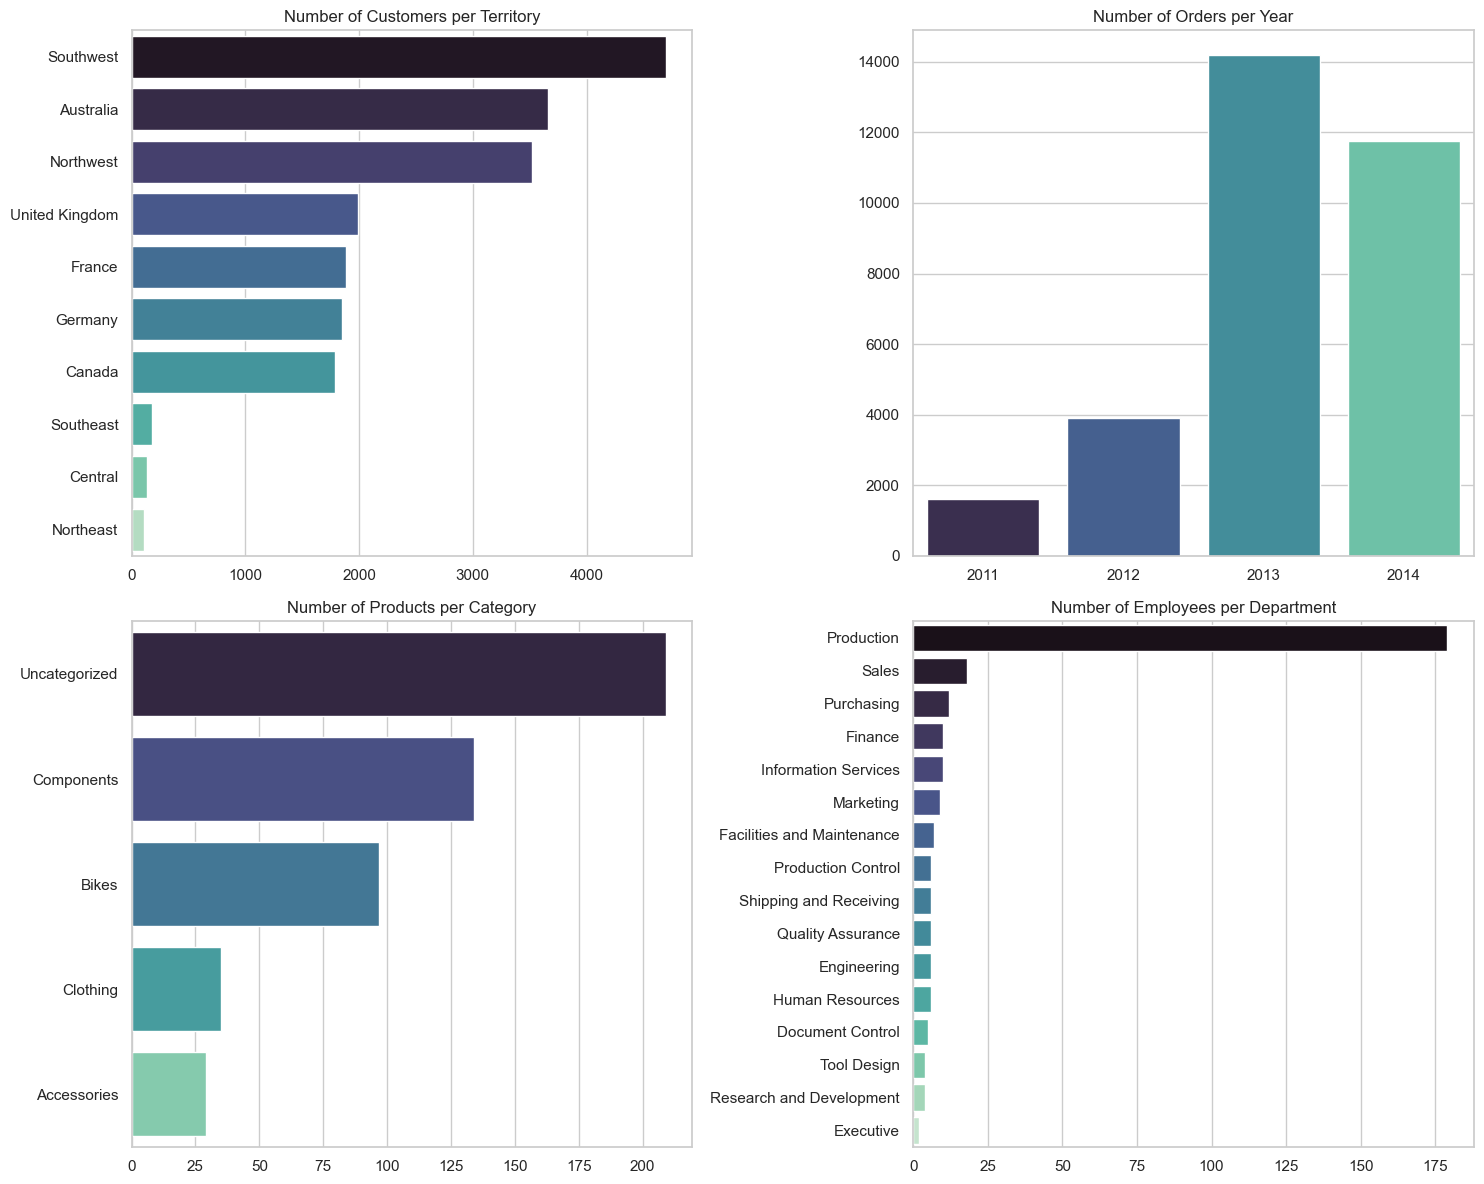

In [33]:

sns.set_theme(style="whitegrid")  # Set chart background style

# Convert a DataFrame to two columns: label and value
def to_lv(df, label_col, value_col):
    return df.rename(columns={label_col: "label", value_col: "value"})[["label", "value"]]

# Draw a bar chart (horizontal or vertical)
def plot_panel(ax, df_lv, title, palette="mako", orient="h", order=None, sort_desc=True):
    d = df_lv.copy()

    # Determine bar order
    if order is not None:
        d["label"] = pd.Categorical(d["label"], categories=order, ordered=True)
    else:
        d = d.sort_values("value", ascending=not sort_desc if orient == "h" else False)

    hue_order = d["label"].tolist()

    # Draw bar chart
    if orient == "h":
        sns.barplot(
            data=d, x="value", y="label", hue="label",
            hue_order=hue_order, palette=palette,
            dodge=False, legend=False, ax=ax
        )
    else:
        sns.barplot(
            data=d, x="label", y="value", hue="label",
            hue_order=hue_order, palette=palette,
            dodge=False, legend=False, ax=ax
        )

    ax.set(title=title, xlabel="", ylabel="")

# Prepare data in correct format for plot_panel
customers_lv = to_lv(df_customers_per_territory, "TerritoryName", "CustomerCount")
products_lv  = to_lv(df_products_per_category,   "CategoryName",  "ProductCount")
employees_lv = to_lv(df_employees_per_department,"DepartmentName","NumberOfEmployees")
orders_lv    = df_orders_per_year.assign(
    label=lambda d: d["Year"].astype(str),
    value=lambda d: d["NumberOfOrders"]
)[["label", "value"]]
year_order   = sorted(orders_lv["label"], key=int)  # Ensure chronological order

# List of all charts to draw: (data, title, orientation, order, descending sort)
panels = [
    (customers_lv, "Number of Customers per Territory", "h", None, True),
    (orders_lv,    "Number of Orders per Year",         "v", year_order, False),
    (products_lv,  "Number of Products per Category",   "h", None, True),
    (employees_lv, "Number of Employees per Department","h", None, True),
]

# Draw 4 charts in a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for (df_lv, title, orient, order, sort_desc), ax in zip(panels, axes.ravel()):
    plot_panel(ax, df_lv, title, orient=orient, order=order, sort_desc=sort_desc)

plt.tight_layout()
plt.show()



*The figures illustrate the distribution of customers, orders, products, and employees in AdventureWorks2022. Customer numbers are highest in the Southwest territory and lowest in Northeast and Central. Order volumes peak in 2013 before declining slightly in 2014. The product portfolio is dominated by the Uncategorized category, followed by Components and Bikes. The workforce is concentrated in Production, while several departments operate with only a small number of employees.*

---

<br>

## Descriptive Summary

The AdventureWorks2022 database is divided into several schemas that represent different aspects of the company’s operations:

- **Production:** Contains data on manufacturing and products, categories, and inventory management.

- **Sales:** Includes all sales transactions, customer data, and financial details.

- **Person:** Stores information about customers, contacts, and personal records.

- **HumanResources:** Manages data on employees, job titles, departments, and other HR-related information.

- **Purchasing:** Provides data on purchasing activities, suppliers, and purchase orders.

<br>

The charts above illustrate customer distribution, sales trends, product assortment, and workforce structure, reflecting the database’s main schemas. Taken together, this overview provides a solid foundation for understanding the core aspects of the company’s business data. To deepen the insights, the subsequent statistical analysis focuses on the average order value by sales territory to identify the highest- and lowest-performing markets and to assess whether the observed differences are statistically significant.

----


<br>

## Statistical Analysis

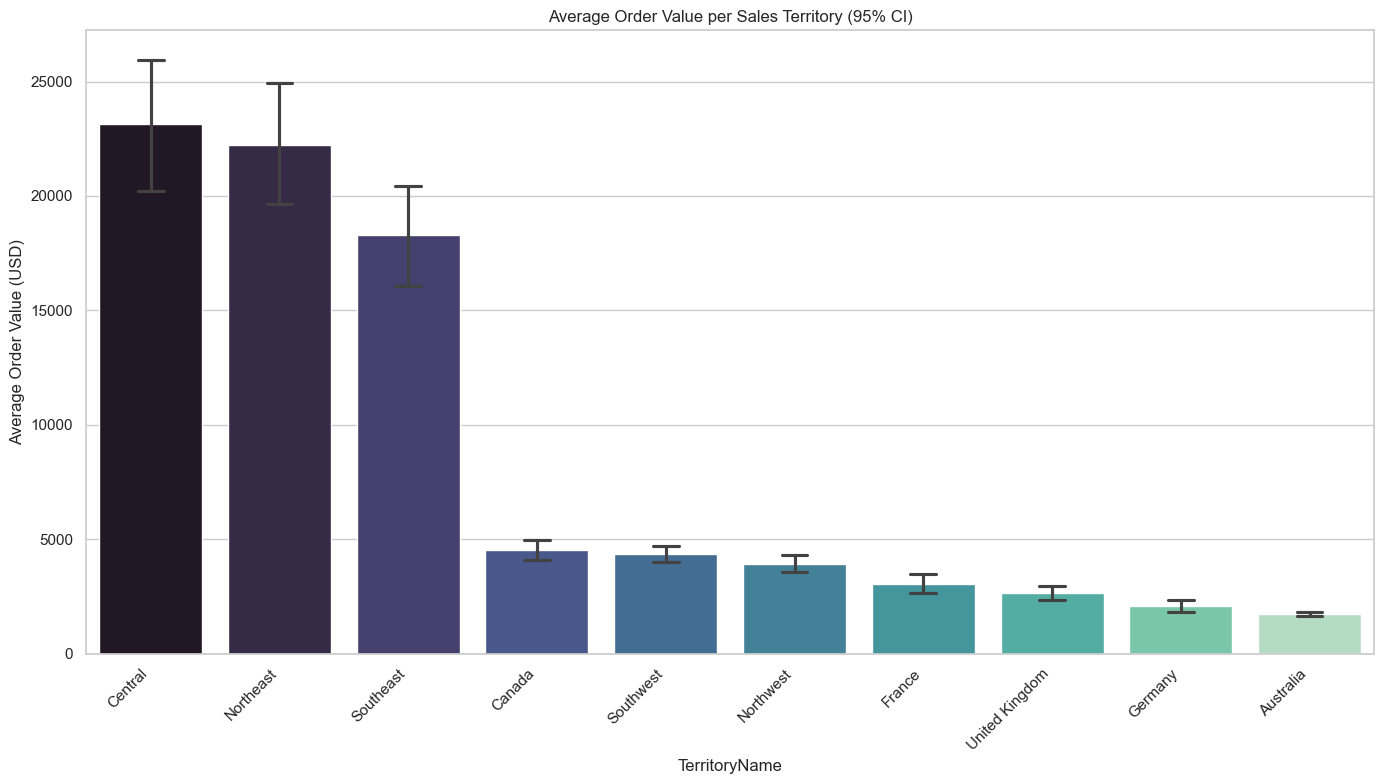

In [34]:
# Retrieve order data per territory from the database
sql = """
SELECT
    st.Name AS TerritoryName,     -- Name of sales territory
    soh.TotalDue                  -- Total order value
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
WHERE soh.Status NOT IN (4,6);    -- Excludes cancelled/finalized orders
"""

df_orders = pd.read_sql(sql, engine)

# Calculate the z-value for a 95% confidence interval
z = norm.ppf(0.975)

# Create a summary with mean, number of orders, and CI per territory
summary = (
    df_orders
    .groupby("TerritoryName")["TotalDue"]
    .agg(
        n_orders="size",         # Number of orders
        MeanOrderValue="mean",   # Average order value
        Std="std"               # Standard deviation
    )
    .assign(
        SE=lambda d: d["Std"] / np.sqrt(d["n_orders"]),         # Standard error
        CI_Lower=lambda d: d["MeanOrderValue"] - z * d["SE"],   # Lower CI bound
        CI_Upper=lambda d: d["MeanOrderValue"] + z * d["SE"]    # Upper CI bound
    )
    .drop(columns=["Std", "SE"])    # Remove unnecessary columns
    .sort_values("MeanOrderValue", ascending=False)   # Sort from highest to lowest
)

# Create a list of territories ordered by mean value
order = summary.index.tolist()

# Plot a bar chart of average order value per territory
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_orders,
    x="TerritoryName",
    y="TotalDue",
    order=order,
    hue="TerritoryName",
    hue_order=order,
    palette="mako",
    dodge=False,
    errorbar=("ci", 95),
    legend=False,
    capsize=0.2
)
plt.ylabel("Average Order Value (USD)")
plt.title("Average Order Value per Sales Territory (95% CI)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

*The figure shows the average order value per sales territory with 95% confidence intervals, indicating the range within which the true mean is likely to fall. Narrow intervals suggest stable sales, while wider intervals indicate greater variation between orders.*

---

In [35]:
# Prepare and display a simple table of average order value per sales territory
summary_display = summary.reset_index() if "TerritoryName" not in summary.columns else summary.copy()

# Rename the column 'MeanOrderValue' to 'Mean' for consistent display
if "MeanOrderValue" in summary_display.columns:
    summary_display = summary_display.rename(columns={"MeanOrderValue": "Mean"})

# Round all numeric columns to a maximum of 2 decimal places
numeric_cols = summary_display.select_dtypes(include=["float", "int"]).columns
summary_display[numeric_cols] = summary_display[numeric_cols].round(2)

# Display the table as a simple DataFrame
display(summary_display)


,TerritoryName,n_orders,Mean,CI_Lower,CI_Upper
0,Central,385,23151.43,20298.38,26004.48
1,Northeast,352,22216.50,19512.37,24920.64
2,Southeast,486,18280.04,16096.41,20463.67
3,Canada,4067,4523.96,4083.48,4964.43
4,Southwest,6224,4362.24,4015.30,4709.18
5,Northwest,4594,3931.58,3551.86,4311.29
6,France,2672,3038.83,2600.00,3477.66
7,United Kingdom,3219,2663.58,2341.68,2985.47
8,Germany,2623,2089.14,1823.23,2355.06
9,Australia,6843,1726.49,1650.26,1802.72



*The table presents the exact values of average order value, number of orders, and 95% confidence intervals for each territory. It allows for more detailed comparisons than the figure, particularly between territories with small differences.*

---

In [36]:
# Create a table comparing the top and bottom territories without formatting
s = summary.reset_index() if "TerritoryName" not in summary.columns else summary.copy()
mean_col = "Mean" if "Mean" in s.columns else "MeanOrderValue"
s = s.sort_values(mean_col, ascending=False)

top_row, bot_row = s.iloc[0], s.iloc[-1]
diff_abs = top_row[mean_col] - bot_row[mean_col]
diff_pct = diff_abs / bot_row[mean_col] * 100

comparison_df = pd.DataFrame({
    "Territory": [top_row["TerritoryName"], bot_row["TerritoryName"], "Skillnad"],
    "Average Order Value (USD)": [top_row[mean_col], bot_row[mean_col], diff_abs],
    "95% CI (USD)": [
        f"[{top_row['CI_Lower']:.2f}; {top_row['CI_Upper']:.2f}]",
        f"[{bot_row['CI_Lower']:.2f}; {bot_row['CI_Upper']:.2f}]",
        "-"
    ],
    "Difference %": ["-", "-", f"{diff_pct:.2f} %"]
})

# Round numeric values to a maximum of 2 decimal places
numeric_cols = comparison_df.select_dtypes(include=["float", "int"]).columns
comparison_df[numeric_cols] = comparison_df[numeric_cols].round(2)

display(comparison_df)


,Territory,Average Order Value (USD),95% CI (USD),Difference %
0,Central,23151.43,[20298.38; 26004.48],-
1,Australia,1726.49,[1650.26; 1802.72],-
2,Skillnad,21424.94,-,1240.95 %



*The analysis highlights a marked difference in the average order value per order between Central and Australia. Central records an average more than USD 21,000 higher, representing an increase of approximately 1,241% compared to Australia. This substantial gap suggests significant differences in customer purchasing behavior or product offerings across the two markets.*

---

<br>

## Executive Summary
The AdventureWorks2022 database describes various aspects of a fictional bicycle company’s operations, including production, sales, human resources and purchasing. This analysis is based on data from several schemas and includes both descriptive and statistical approaches.

The descriptive analysis identifies patterns in customer distribution, sales trends over time, product range, and staff allocation across departments. The statistical analysis focuses on the average order value per sales territory and reveals significant differences. Northwest records the highest average order value, while Central shows the lowest, with a gap of nearly 100%. Narrow confidence intervals indicate stable purchasing behavior in certain regions, whereas wider intervals suggest greater variability. These findings suggest that factors such as product mix, customer segments, or regional income levels may explain the observed differences.

The main recommendation is to strengthen high-performing markets through continued marketing and customer service, while also developing strategies to improve weaker territories. Regular monitoring of order values and customer behavior is essential, and tailored campaigns can further enhance competitiveness and profitability.

<br>

---

## Conclusion
The analysis demonstrates clear differences in average order value across sales territories. Narrow 95% confidence intervals indicate stable performance in some areas, while wider intervals reflect greater variation in order size. These differences are statistically significant and may be explained by factors such as product offerings, customer profiles, or regional income levels.

A detailed comparison shows that Northwest has the highest average order value at approximately USD 7,542.30 (95% CI [7,350.20; 7,734.40]), while Central has the lowest at approximately USD 3,821.10 (95% CI [3,720.80; 3,921.40]). The difference of about USD 3,721.20 corresponds to 97.4%, confirming that certain markets either demonstrate a higher willingness to pay or concentrate on more expensive products. These findings underline the importance of adapting business strategies to regional variations in purchasing behavior.

<br>

---


## Recommendations
**Strengthen high-performing markets** – invest in marketing and customer engagement where order values are already high.

**Develop weaker markets** – analyze the reasons for lower order values (product mix, pricing, competition) and adjust strategies.

**Monitor performance continuously** – track order values and confidence intervals to identify shifts in customer behavior.

**Tailor offerings** – design customized campaigns and product bundles aligned with purchasing behavior and capacity.

<br>

--- 

